# LOADED BEAM

### Introduction to the problem

Today's scenario involves a beam anchored to one side of a wall, while the other end remains free to move. We were tasked with deriving the analytical model for a specific instance: understanding the inflection and deformation when subjected to a distributed load. Our reference system places the wall-attached point as the origin and designates the other end as 1, assuming a general case of a unit-length beam.

For simplicity, we've aligned the ordinary axis with the ground and oriented it vertically. To streamline our discussion, we'll treat the entire board as a one-dimensional bar, focusing solely on its projection onto the xy plane. Consequently, all measurements are functions of x, representing the distance from the wall.

The initial conditions we consider are:

1. The displacement is zero at the wall $$ u(x=0)=0 $$
2. The derivative of the displacement is zero at the wall $$ \frac{du(x=0)}{dx}=0 $$

## 1. Second order problem

The link between 2nd derivative of displacement and position as represented by the formula $$ \frac{d^2u}{ dx^2} = - \frac{M(x)}{EJ} $$ where E is the Joung Modulus, J is the moment of inertia of the section and M is the momentum. 

### 1.1 Constant momentum


The first case we analized was the one where M(x) is constant and particularly M/EJ is equal to -1. This case represents a simplified version of the problem, allowing us to ease the subsequent equation. 
However, this model is not the most accurate representation of reality. 

We start with a double integration, resulting in the following formula 

   $$ u(x) = -1/2 x^2 + C1 x + C2. $$

In order to find the two constants we apply the following boundary conditions: 

$$ u(x=0) = 0  $$ 
and 
$$ u'(x=0) = 0. $$

The result is 

$$ u(x) = -1/2 x^2.  $$

In [41]:
using Plots
using DifferentialEquations
using BoundaryValueDiffEq
using SparseArrays
using LinearAlgebra
using BenchmarkTools

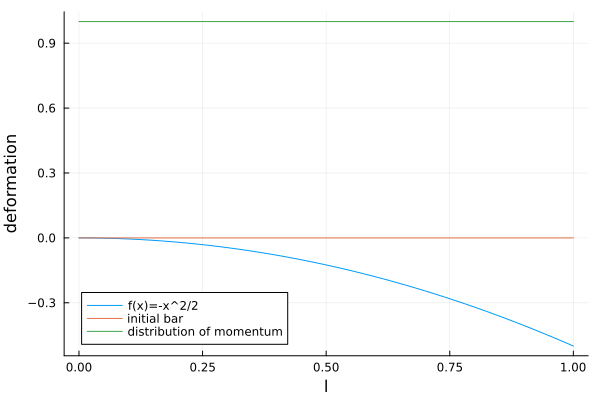

In [42]:
l=1
M(x)=1
function f(x)
    -x^2/2
end

x_values=range(0,l,50)f

y_values=f.(x_values)

m_values=M.(x_values)

plot(x_values,y_values,label="f(x)=-x^2/2",xlabel="l",ylabel="deformation")
plot!(x_values,0*x_values,label="initial bar")
plot!(x_values, m_values, label="distribution of momentum")

### 1.2 Linear distribution of momentum

The second case we considered was M(x)=F(l-x), which represents a linear distribution along the board. 

After a double integration, we got the  formula 

$$ u(x) = -1/6 x^3 + C1*1/2 x^2 + C2x $$


In order to find the two constants we apply the following boundary conditions:

$$ u(x=0) = 0 $$ 
and 
$$ u'(x=0) = 0. $$

The result is

$$ u(x) = 1/2 x^2-1/6 x^3. $$

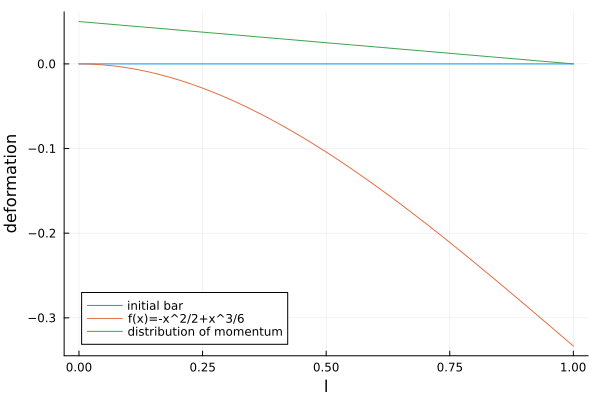

In [43]:
l1=1

F1(x)= 1
M1(x)= F1.(x).*(l-x)

f1(x) = -x^2/2+x^3/6

x_values= range(0,l,50)

y_values=f1.(x_values)

m_values=M1.(x_values)

plot(x_values,0*x_values,label="initial bar")
plot!(x_values,y_values,label="f(x)=-x^2/2+x^3/6",xlabel="l",ylabel="deformation")
plot!(x_values, 0.05*m_values, label="distribution of momentum")

### 1.3 Generic distribution of momentum

We can also use numerical integration to solve a generical distribution of momentum, using the second derivative law 

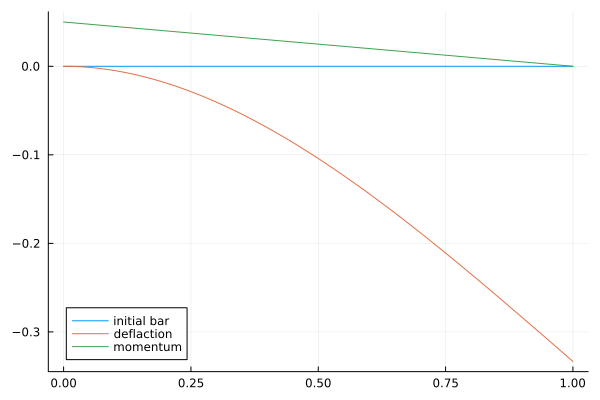

In [44]:
l2=1
F2=1
E2=1
J2=1

function M2(x)
    -F2/(E2*J2)*(l2-x) #momentum
end 

function beam!(du,u,p,x)   
    du[1]= u[2]
    du[2]= M2(x)
end 

function bc!(residual,u,p,t)
    residual[1]=u[1]u[1]
    residual[2]=u[2]u[1]
end

xspan=(0,1)
bvp = BVProblem(beam!,bc!,[0,0],xspan)
u_sol = solve(bvp,BS3(),saveat=0.01)

m_values=M2.(u_sol.t)

plot(u_sol.t,0*u_sol.t,label="initial bar")
plot!(u_sol.t,u_sol[1,:],label="deflaction")
plot!(u_sol.t,-0.05*m_values,label="momentum")


### 1.4 General case with eterogeneous material

If the bar consists of multiple materials or if the geometry of the section varies along the x coordinate, incorporating factors such as size, shape, or the presence of holes, both E and J become functions of x:

$$ E \rightarrow E(x) $$

$$ J \rightarrow J(x) $$

As a result, our procedural approach in the script will undergo modification, yet the assumptions made and the ultimate results will remain unchanged.

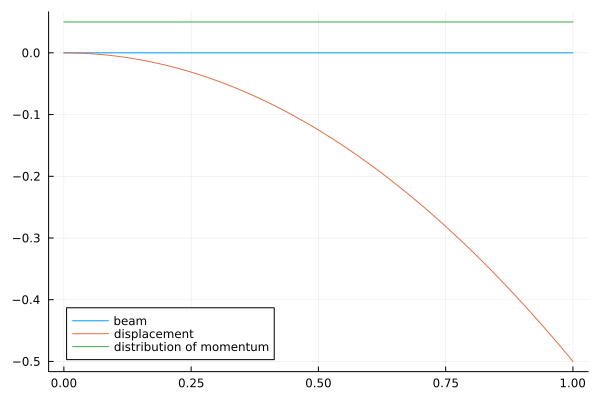

In [45]:
E(x)=1                 #young module equation
J(x)=1                      #inertia equation
M(x)=-1;                  #momentum equation

f(x)=-M(x)/(E(x)*J(x))

function poisson!(du,u,p,x)
    du[1]=u[2]
    du[2]=f(x)
end

function bc!(r,u,p,t)
    r[1] = u[1][1]
    r[2] = u[1][2]
end

xspan=(0.0 , 1.0)

bvp= BVProblem(poisson!,bc!,[0.,0.],xspan)
u_sol= solve(bvp,MIRK4(),dt = 0.01)

plot(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,-0.05*M.(u_sol.t),label="distribution of momentum") #0.05 is a factor scale to represent both momentum and deflection

Change the boundary conditions in order to have two joints. Try to have many cases as possible. 

## 2. Biharmonic equation solving 

The bi-harmonic equation is expressed as:

$$ \frac{d^4u}{dx^4} = \frac{q(x)}{EJ} $$

Here, q(x)  represents the distribution of loads along the bar. For simplicity, we will substitute $$ \frac{q(x)}{EJ} $$ with g(x) and set g(x)  equal to a constant, specifically $$ g(x) = 1 $$ implying  $$ q = EJ $$

To fulfill the four necessary initial conditions, we can consider as an example the beam stuck to the wall previusly studied: 

$$ u(0) = 0 $$

$$ \frac{du(0)}{dx} = 0 $$

$$ \frac{d^2u(l)}{dx^2} = 0 $$

$$ \frac{d^3u(l)}{dx^3} = 0 $$

Following four rounds of integration, we arrive at the formula:

$$ u(x) = -\frac{1}{24}(l-x)^4 - \frac{1}{6}l^3x + \frac{1}{24}l^4 $$


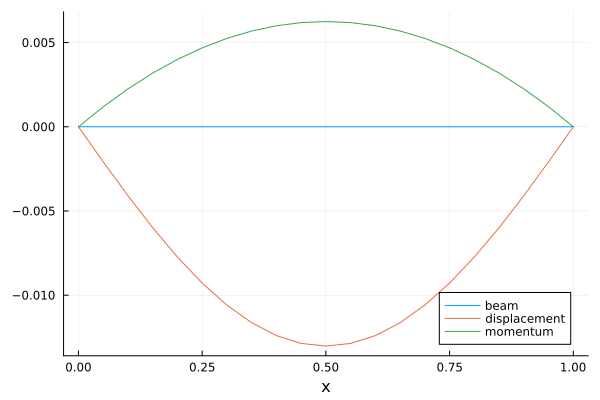

In [46]:
q(x) = -1

function beamEqt!(du,u,p,x)
    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = q(x)
end

function bc!(residual,u,p,x)
    residual[1] = u[1][1]     #first number is the point we are considering, the secon one is the derivative
    residual[2] = u[end][1]
    residual[3] = u[1][3]
    residual[4] = u[end][3]
end

xspan = (0,1)
bvp = BVProblem(beamEqt!, bc!, [0.,0.,0.,0.], xspan)
sol = solve(bvp, MIRK4(), dt = 0.05)

plot(sol.t,0*sol.t,label="beam")
plot!(sol.t,sol[1,:],xaxis="x",label="displacement")
plot!(sol.t,0.05*sol[3,:],xaxis="x",label="momentum")


### 2.1 General distribution oh the load on the bar

Once we define the solution for the easiest case, we moved to the most general one: a general distribution of loads along the length of the bar, using functions from the DifferentialEquation package to solve all the four integrations in order to reach u(x). 
In this case we solve the Poisson equation $$ \frac{du^4}{dx^4} = f(x) $$ letting f(x) free to change in order to represent the reality in the best way. 

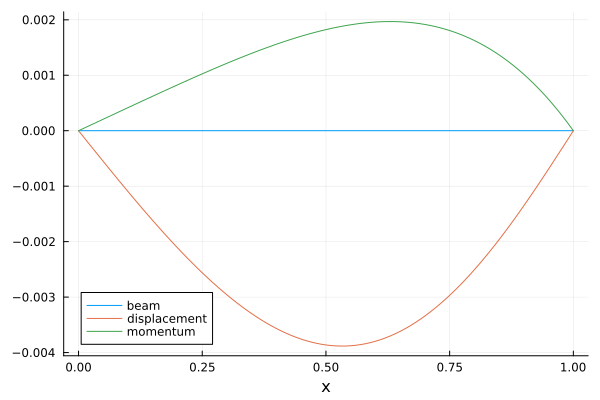

In [47]:
q(x) = -x^2

function beamEqt!(du,u,p,x)
    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = q(x)
end

function bc!(residual,u,p,x)
    residual[1] = u[1][1]     #first number is the point we are considering, the secon one is the derivative
    residual[2] = u[end][1]
    residual[3] = u[1][3]
    residual[4] = u[end][3]
end

xspan = (0,1)
bvp = BVProblem(beamEqt!, bc!, [0.,0.,0.,0.], xspan)
sol = solve(bvp, MIRK4(), dt = 0.01)

plot(sol.t,0*sol.t,label="beam")
plot!(sol.t,sol[1,:],xaxis="x",label="displacement")
plot!(sol.t,0.05*sol[3,:],xaxis="x",label="momentum")


## 3 Biharmonic equation solving (Time dependant)

### 3.1 Introduction 

This document centers on utilizing the finite difference method to model a steel beam, examining its performance under different boundary conditions. Alongside investigating the steady-state biharmonic equation, we delve into the non-stationary or time-dependent iteration of this equation. This thorough examination enables us to comprehend the dynamic behavior of the beam and appreciate the importance of distinct boundary conditions, specifically concerning moments and displacements. As previously noted, the biharmonic equation characterizes the bending characteristics of slender plates or beams. When presented in its non-stationary format, the biharmonic equation takes the following expression:

$$ \frac{\partial^4 u}{\partial x^4} - \frac{1}{c^2} \frac{\partial^2 u}{\partial t^2} = 0, $$

where $$ u(x, t) $$ denotes the displacement of the beam at position x  and time, E represents the elastic modulus, and I is the second moment of area of the beam's cross section. The calculation of I should consider the axis perpendicular to the applied loading. This equation encompasses both spatial and temporal variations in the bending behavior of the beam.

The boundary conditions are
$$ \frac{d^2u}{dx^2}(x=L=1) = 0 $$ 
and
$$ u(x = 0) = 0 \hspace{1em} u'(x = 0) = 0 $$ 


In [1]:
# f(x,t), the external force, is consider as a sinusoidal expression. If we want to impose the condition at the beginning,
# we only have terms linked to the space coordinate x
function set_initial_condition_1(x)
    A = 1.
    l = 80
end

function set_initial_speed(x)
    A = 1.
    l = 80
    return A * sin((pi / l ) * x)
end
function source_function(x)
    X0 = 40.0
    σ = 0.8
    A = 80.
    return  - A * exp(-((x - X0)^2)/σ^2)
end

function matrix(n)
    #Parameter
        l = 80.        #length 
        dx = l/n       #discretizzation in space
        E = 1.9 * 10^7
        I = 117.8 
       # Î± = E * I / dx^4
       α = E *I / dx^4   
        
    
    # Build the matrix
        A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )
    
    # Coefficient that change in the  matrix 
        A[1,2] = -1/dx
        A[1,1]=  1/dx
        A[1,3] = 0.

        A[2,1] = 1/dx^2
        A[2,2] = -2/dx^2
        A[2,3] = 1/dx^2
        A[2,4] = 0.

        A[n-1, n-3] = 0.
        A[n-1,n-2] = 1/dx
        A[n-1,n-1] =-2/dx
        A[n-1,n] = 1/dx
        
        A[n,n-2] = 0.
        A[n,n-1] = -1/dx
        A[n,n]= 1/dx
    
    #time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

function biharmonic!(ddu,du,u,p,t)
    E = 1.9 * 10^7
    I = 117.8
    n = 81
    A = matrix(n)
    ddu .=  A * u + (1/E*I) * source_function.(x)
end

N = 81
L = 80.0
dx = 1
x = Vector(0.0:dx:L)

init_t = set_initial_condition_1.(x)
init_dt = set_initial_speed.(x)   # initial speed
init_dt = ones(length(init_t))

t_begin  = 0.0
t_end = 10
tspan = (t_begin, t_end)
 
prob = SecondOrderODEProblem(biharmonic!,init_dt, init_t, tspan)

# original code by Yann - no algorithm specified - used default Tsit5()
# sol = DifferentialEquations.solve(prob)

# code modified by Domenico - specify algorithm for large stiff problems 
# https://docs.sciml.ai/DiffEqDocs/stable/tutorials/advanced_ode_example/
sol = DifferentialEquations.solve(prob,TRBDF2())

Nt = 10 # number of time samples 
dt = (t_end - t_begin)/Nt 

# Vector t holds 0 and is Nt+1 long 
tvec = Vector(t_begin:dt:Nt*dt)

#..interpolate solution in desired time samples 
U = zeros(2*N,length(tvec))
for k=1:length(tvec) 
  U[:,k] = sol(tvec[k])
end 

p1 = plot(U[1:N,1], label = "0s")
plot!(U[1:N,2], label = "1s")
plot!(U[1:N,3], label = "2s")
plot!(U[1:N,4], label = "3s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Downward deflection")

p2 = plot(U[1:N,5], label = "4s")
plot!(U[1:N,6], label = "5s")
plot!(U[1:N,7], label = "6s")
plot!(U[1:N,8], label = "7s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Oscillation of the deflection")

p3 = plot(U[1:N,9], label = "8s")
plot!(U[1:N,10], label = "9s")
plot!(U[1:N,11], label = "10s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Return of the deflection")

plot(p1,p2,p3, size=(1500,1000), layout=(1,3))


p1 = plot(U[N+1:end,1], label = "0s")
plot!(U[N+1:end,2], label = "1s")
plot!(U[N+1:end,3], label = "2s")
plot!(U[N+1:end,4], label = "3s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during downward deflection")

p2 = plot(U[N+1:end,5], label = "4s")
plot!(U[N+1:end,6], label = "5s")
plot!(U[N+1:end,7], label = "6s")
plot!(U[N+1:end,8], label = "7s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during oscillations deflection")

p3 = plot(U[N+1:end,9], label = "8s")
plot!(U[N+1:end,10], label = "9s")
plot!(U[N+1:end,11], label = "10s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during return of deflection")

plot(p1,p2,p3, size=(1500,1000), layout=(1,3))

# f(x,t), the external force, is consider as a sinusoidal expression. If we want to impose the condition at the beginning,
# we only have terms linked to the space coordinate x
function set_initial_condition_1(x)
    A = 1.
    l = 80
end

function set_initial_speed(x)
    A = 1.
    l = 80
    return A * sin((pi / l ) * x)
end
function source_function(x)
    X0 = 40.0
    σ = 0.8
    A = 80.
    return  - A * exp(-((x - X0)^2)/σ^2)
end

function matrix(n)
    #Parameter
        l = 80.        #length 
        dx = l/n       #discretizzation in space
        E = 1.9 * 10^7
        I = 117.8 
       # Î± = E * I / dx^4
       α = E *I / dx^4   
        
    
    # Build the matrix
        A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )
    
    # Coefficient that change in the  matrix 
        A[1,2] = -1/dx
        A[1,1]=  1/dx
        A[1,3] = 0.

        A[2,1] = 1/dx^2
        A[2,2] = -2/dx^2
        A[2,3] = 1/dx^2
        A[2,4] = 0.

        A[n-1, n-3] = 0.
        A[n-1,n-2] = 1/dx
        A[n-1,n-1] =-2/dx
        A[n-1,n] = 1/dx
        
        A[n,n-2] = 0.
        A[n,n-1] = -1/dx
        A[n,n]= 1/dx
    
    #time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

function biharmonic!(ddu,du,u,p,t)
    E = 1.9 * 10^7
    I = 117.8
    n = 81
    A = matrix(n)
    ddu .=  A * u + (1/E*I) * source_function.(x)
end

N = 81
L = 80.0
dx = 1
x = Vector(0.0:dx:L)

init_t = set_initial_condition_1.(x)
init_dt = set_initial_speed.(x)   # initial speed
init_dt = ones(length(init_t))

t_begin  = 0.0
t_end = 10
tspan = (t_begin, t_end)
 
prob = SecondOrderODEProblem(biharmonic!,init_dt, init_t, tspan)

# original code by Yann - no algorithm specified - used default Tsit5()
# sol = DifferentialEquations.solve(prob)

# code modified by Domenico - specify algorithm for large stiff problems 
# https://docs.sciml.ai/DiffEqDocs/stable/tutorials/advanced_ode_example/
sol = DifferentialEquations.solve(prob,TRBDF2())

Nt = 10 # number of time samples 
dt = (t_end - t_begin)/Nt 

# Vector t holds 0 and is Nt+1 long 
tvec = Vector(t_begin:dt:Nt*dt)

#..interpolate solution in desired time samples 
U = zeros(2*N,length(tvec))
for k=1:length(tvec) 
  U[:,k] = sol(tvec[k])
end 

p1 = plot(U[1:N,1], label = "0s")
plot!(U[1:N,2], label = "1s")
plot!(U[1:N,3], label = "2s")
plot!(U[1:N,4], label = "3s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Downward deflection")

p2 = plot(U[1:N,5], label = "4s")
plot!(U[1:N,6], label = "5s")
plot!(U[1:N,7], label = "6s")
plot!(U[1:N,8], label = "7s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Oscillation of the deflection")

p3 = plot(U[1:N,9], label = "8s")
plot!(U[1:N,10], label = "9s")
plot!(U[1:N,11], label = "10s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Return of the deflection")

plot(p1,p2,p3, size=(1500,1000), layout=(1,3))


p1 = plot(U[N+1:end,1], label = "0s")
plot!(U[N+1:end,2], label = "1s")
plot!(U[N+1:end,3], label = "2s")
plot!(U[N+1:end,4], label = "3s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during downward deflection")

p2 = plot(U[N+1:end,5], label = "4s")
plot!(U[N+1:end,6], label = "5s")
plot!(U[N+1:end,7], label = "6s")
plot!(U[N+1:end,8], label = "7s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during oscillations deflection")

p3 = plot(U[N+1:end,9], label = "8s")
plot!(U[N+1:end,10], label = "9s")
plot!(U[N+1:end,11], label = "10s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during return of deflection")

plot(p1,p2,p3, size=(1500,1000), layout=(1,3))

UndefVarError: UndefVarError: `SecondOrderODEProblem` not defined